#Objective:

To Predict/forecast Sales for next 6 weeks for Rossman stores

Store Numbers: 1,3,8,9,13,25,29,31 and 46.

####Data provided:
1. Train  : sales data for individual stores at a daily level along with the details about the day
2. Store : store table contains the metadata for every single store

# Data Sourcing

In [149]:
# importing all necessary libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import os

import warnings
warnings.filterwarnings('ignore')
import itertools
#for time series model 
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api  as sm


In [150]:
#import from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
!cp /content/drive/MyDrive/Dataset/store.csv .
!cp /content/drive/MyDrive/Dataset/train.csv .


In [152]:
store = pd.read_csv("store.csv")
train = pd.read_csv("train.csv")

In [153]:
store.shape


(1115, 10)

In [154]:
train.shape


(1017209, 9)

In [155]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [156]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [157]:
train.Store.nunique()

1115

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [159]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


# Data Cleaning

In [160]:
train.describe()[['Sales','Customers']].loc['min']

Sales        0.0
Customers    0.0
Name: min, dtype: float64

In [161]:
train.describe()[['Sales','Customers']].loc['max']

Sales        41551.0
Customers     7388.0
Name: max, dtype: float64

In [162]:
train['Store'].value_counts().head(50)

1023    942
666     942
675     942
163     942
674     942
162     942
673     942
161     942
672     942
160     942
158     942
157     942
668     942
156     942
667     942
154     942
657     942
665     942
153     942
664     942
152     942
663     942
151     942
662     942
150     942
661     942
148     942
659     942
147     942
658     942
676     942
166     942
678     942
167     942
695     942
182     942
693     942
692     942
180     942
691     942
179     942
690     942
178     942
689     942
177     942
688     942
176     942
687     942
175     942
686     942
Name: Store, dtype: int64

In [163]:
train.DayOfWeek.value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [164]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [165]:
train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [166]:
train['Date']= pd.to_datetime(train['Date'],format = '%Y-%m-%d')


In [167]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [168]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


Removing null values

In [169]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [170]:
store[~store['Promo2SinceYear'].isna()].iloc[0]

Store                                      2
StoreType                                  a
Assortment                                 a
CompetitionDistance                      570
CompetitionOpenSinceMonth                 11
CompetitionOpenSinceYear                2007
Promo2                                     1
Promo2SinceWeek                           13
Promo2SinceYear                         2010
PromoInterval                Jan,Apr,Jul,Oct
Name: 1, dtype: object

In [171]:
store['Promo2SinceWeek'].fillna(0,inplace = True)
store['Promo2SinceYear'].fillna(store['Promo2SinceYear'].mode()[0],inplace = True)
store['PromoInterval'].fillna(store['PromoInterval'].mode()[0],inplace = True)

In [172]:
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].mode()[0],inplace = True)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].max(),inplace = True)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode()[0],inplace = True)

In [173]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

# Exploratory Data Analysis

In [174]:
ross = train.merge(store,on = 'Store',how = 'left')

In [175]:
ross.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"


In [176]:
print(ross.isnull().sum().sum())

0


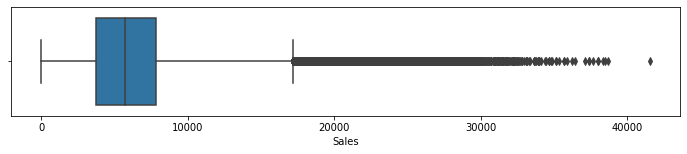

In [177]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=ross['Sales'],whis=[0,99])

In [178]:
ross.Sales.quantile(0.99)

17160.0

####Outlier removal

In [179]:
ross=ross[ross['Sales']<ross['Sales'].quantile(0.99)]

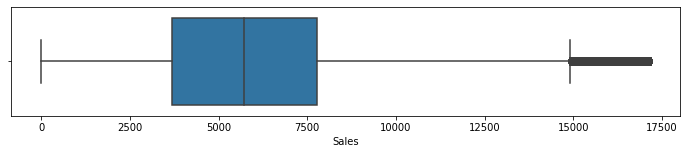

In [180]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=ross['Sales'],whis=[0,99])

In [181]:
df = ross[ross['Store'].isin([1,3,8,9,13,25,29,31,46])]

In [182]:
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['weekofyear'] = df['Date'].dt.weekofyear

In [183]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,weekofyear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,9.0,2013.0,1,45.0,2009.0,"Feb,May,Aug,Nov",31,7,2015,31


In [184]:
df['StateHoliday'].value_counts()

0    6825
0    1018
a     163
b      54
c      32
Name: StateHoliday, dtype: int64

In [185]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [186]:
df['StateHoliday'] = df['StateHoliday'].map({'a':1,'b':2,'c':3,'0':0,0:0})

In [187]:
df['StateHoliday'].value_counts()

0    7843
1     163
2      54
3      32
Name: StateHoliday, dtype: int64

In [188]:
df['Assortment'] = df['Assortment'].map({'a':1,'b':2,'c':3,'0':0,0:0})

In [189]:
df['Assortment'].value_counts()

1    5266
3    2826
Name: Assortment, dtype: int64

In [190]:
df['StoreType'] = df['StoreType'].map({'a':1,'b':2,'c':3,'d':4,'0':0,0:0})

In [191]:
df['StoreType'].value_counts()

1    2826
4    2642
3    2624
Name: StoreType, dtype: int64

New variable creation

In [192]:
df['Sales/Cust']= df['Sales']/df['Customers']


In [193]:
df['Sales/Cust'].describe()

count    6661.000000
mean        9.523112
std         2.004334
min         5.706169
25%         7.912281
50%         9.312689
75%        10.874426
max        24.901205
Name: Sales/Cust, dtype: float64

In [194]:
MonthName = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df['MonthName']=df.month.map(MonthName)

In [195]:
df['CompetitionOpen']= 12* (df.year - df.CompetitionOpenSinceYear)+(df.month - df.CompetitionOpenSinceMonth)
df['CompetitionOpen']= df.CompetitionOpen.apply(lambda x:x if x>0 else 0)
df['PromoOpen']= 12* (df.year - df.Promo2SinceYear)+((df.weekofyear - df.Promo2SinceWeek)/4.0)
df['PromoOpen']= df.PromoOpen.apply(lambda x:x if x>0 else 0)


In [196]:
df.loc[df.PromoInterval == 0, 'PromoInterval'] = ''
df['IsPromoMonth'] = 0
for interval in df.PromoInterval.unique():
  if interval != '':
    for month in interval.split(','):
      df.loc[(df.MonthName == month) & (df.PromoInterval == interval),'IsPromoMonth'] = 1

In [197]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,weekofyear,Sales/Cust,MonthName,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,9.482883,Jul,82.0,55.75,1
2,3,5,2015-07-31,8314,821,1,1,0,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,10.126675,Jul,103.0,52.25,1
7,8,5,2015-07-31,8492,833,1,1,0,1,1,1,7520.0,10.0,2014.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,10.194478,Jul,9.0,55.75,1
8,9,5,2015-07-31,8565,687,1,1,0,1,1,3,2030.0,8.0,2000.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,12.467249,Jul,179.0,55.75,1
12,13,5,2015-07-31,8821,568,1,1,0,0,4,1,310.0,9.0,2013.0,1,45.0,2009.0,"Feb,May,Aug,Nov",31,7,2015,31,15.529930,Jul,22.0,68.50,0


####Heatmap

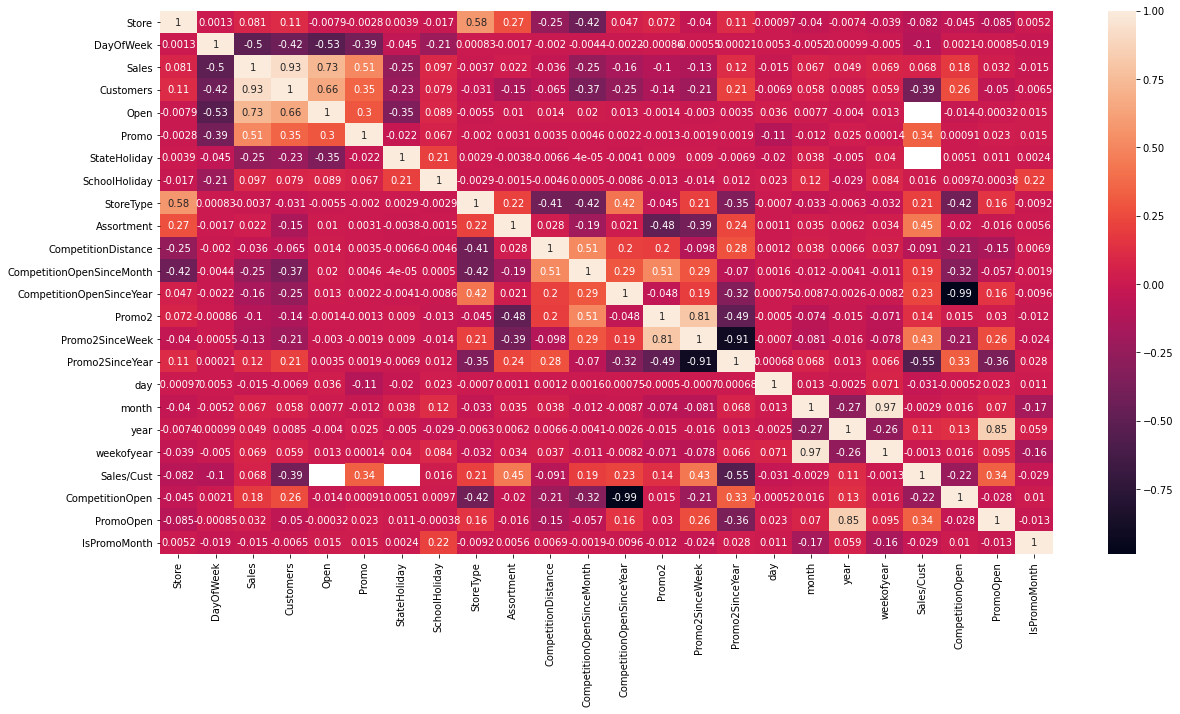

In [198]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(),annot = True)

Based on heatmap , we see Sales depends on customers,Open and Promo 

In [199]:
df2=df.set_index('Date')

In [200]:
df2.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,weekofyear,Sales/Cust,MonthName,CompetitionOpen,PromoOpen,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,9.482883,Jul,82.0,55.75,1
2015-07-31,3,5,8314,821,1,1,0,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,10.126675,Jul,103.0,52.25,1
2015-07-31,8,5,8492,833,1,1,0,1,1,1,7520.0,10.0,2014.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,10.194478,Jul,9.0,55.75,1
2015-07-31,9,5,8565,687,1,1,0,1,1,3,2030.0,8.0,2000.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,12.467249,Jul,179.0,55.75,1
2015-07-31,13,5,8821,568,1,1,0,0,4,1,310.0,9.0,2013.0,1,45.0,2009.0,"Feb,May,Aug,Nov",31,7,2015,31,15.529930,Jul,22.0,68.50,0


In [201]:
df2['Sales'] = df2['Sales']*1.0

In [202]:
df3=df2.sort_values(['Date'],ascending= False)

In [203]:
df3.head(1908)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,weekofyear,Sales/Cust,MonthName,CompetitionOpen,PromoOpen,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263.0,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,9.482883,Jul,82.0,55.75,1
2015-07-31,8,5,8492.0,833,1,1,0,1,1,1,7520.0,10.0,2014.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,10.194478,Jul,9.0,55.75,1
2015-07-31,9,5,8565.0,687,1,1,0,1,1,3,2030.0,8.0,2000.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,12.467249,Jul,179.0,55.75,1
2015-07-31,13,5,8821.0,568,1,1,0,0,4,1,310.0,9.0,2013.0,1,45.0,2009.0,"Feb,May,Aug,Nov",31,7,2015,31,15.529930,Jul,22.0,68.50,0
2015-07-31,25,5,14180.0,1586,1,1,0,1,3,1,430.0,4.0,2003.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,8.940731,Jul,147.0,55.75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01,25,4,0.0,0,0,0,1,1,3,1,430.0,4.0,2003.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",1,1,2015,1,NaN,Jan,141.0,48.25,1
2015-01-01,29,4,0.0,0,0,0,1,1,4,3,2170.0,9.0,2013.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",1,1,2015,1,NaN,Jan,16.0,48.25,1
2015-01-01,31,4,0.0,0,0,0,1,1,4,3,9800.0,7.0,2012.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",1,1,2015,1,NaN,Jan,30.0,48.25,1


# Train and Test Data Split

In [204]:

train_len = 1908
df_test = df3[0:train_len]
df_train = df3[train_len:]

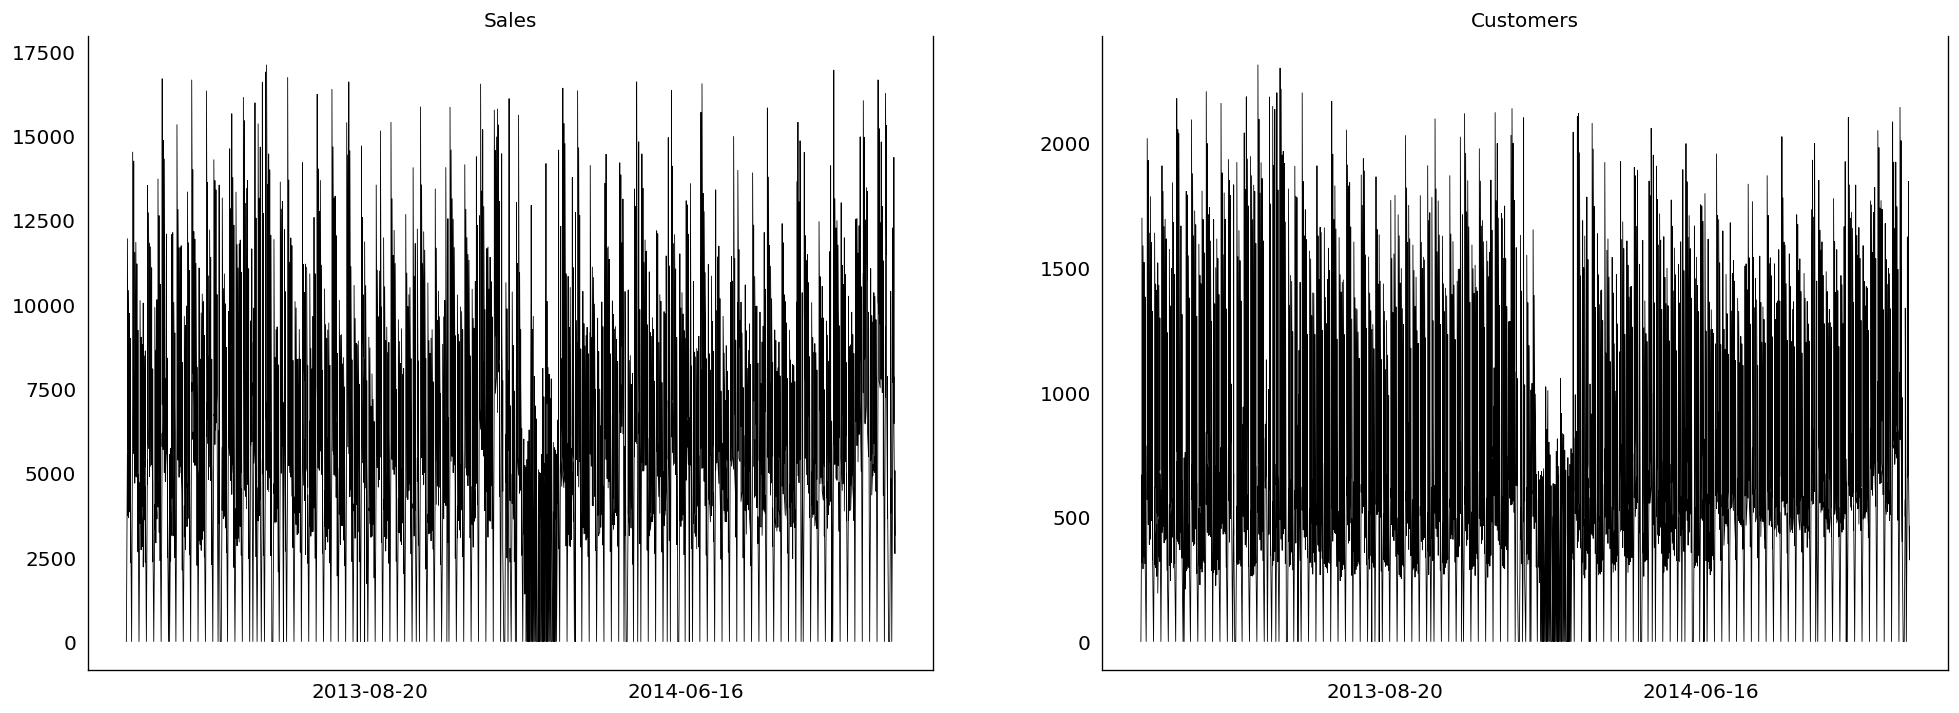

In [205]:
ls=['Sales','Customers'] #ortmePromoInterval	day	month	year	weekofyear	Sales/Cust	MonthName	CompetitionOpen	PromoOpen	IsPromoMonthDate										
df_p=df_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi= 120, figsize=(20,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df_p[df_p.columns[i]], color='black', linewidth=0.5)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df_p.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

# Time series analysis


## Model Building

In [206]:
#isin([1,3,8,9,13,25,29,31,46])]
sales_1 = df3[df3.Store == 1]['Sales']
sales_3 = df3[df3.Store == 3]['Sales']
sales_8 = df3[df3.Store == 8]['Sales']
sales_9 = df3[df3.Store == 9]['Sales']
sales_13 = df3[df3.Store == 13]['Sales']
sales_25 = df3[df3.Store == 25]['Sales']
sales_29 = df3[df3.Store == 29]['Sales']
sales_31 = df3[df3.Store == 31]['Sales']
sales_46 = df3[df3.Store == 46]['Sales']



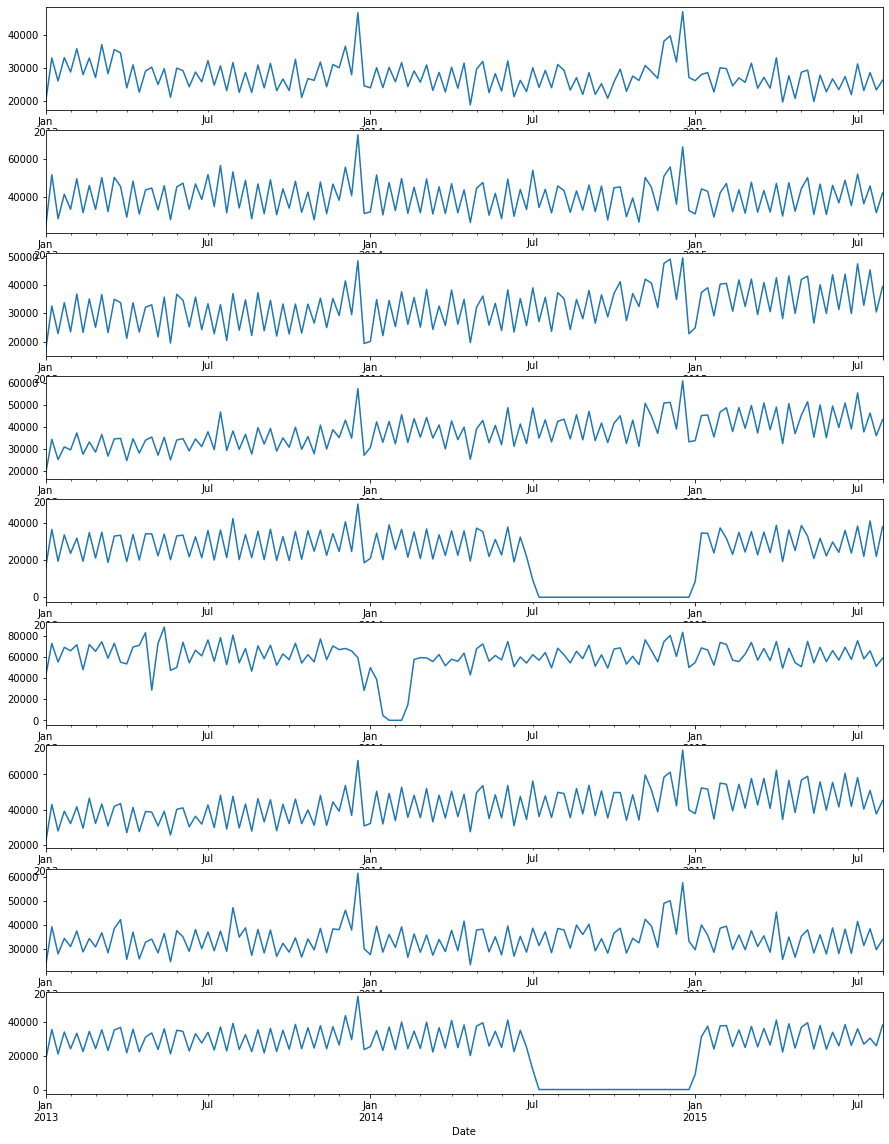

In [207]:
f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9)=plt.subplots(9,figsize=(15,20))
sales_1.resample('W').sum().plot(ax=ax1)
sales_3.resample('W').sum().plot(ax=ax2)
sales_8.resample('W').sum().plot(ax=ax3)
sales_9.resample('W').sum().plot(ax=ax4)
sales_13.resample('W').sum().plot(ax=ax5)
sales_25.resample('W').sum().plot(ax=ax6)
sales_29.resample('W').sum().plot(ax=ax7)
sales_31.resample('W').sum().plot(ax=ax8)
sales_46.resample('W').sum().plot(ax=ax9)

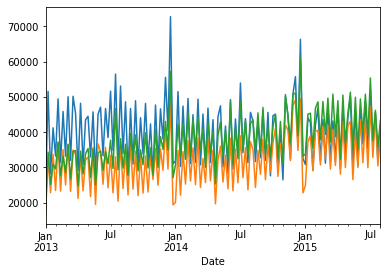

In [208]:
sales_3.resample('W').sum().plot()
sales_8.resample('W').sum().plot()
sales_9.resample('W').sum().plot()

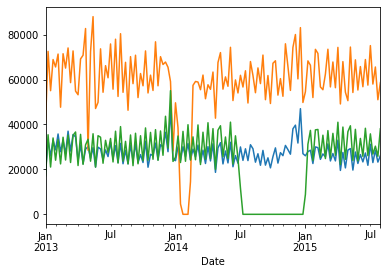

In [209]:

sales_1.resample('W').sum().plot()

sales_25.resample('W').sum().plot()

sales_46.resample('W').sum().plot()


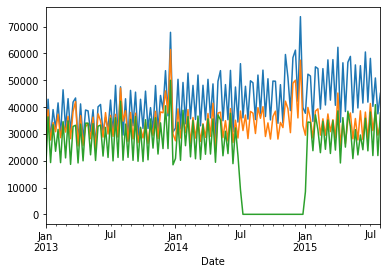

In [210]:
sales_29.resample('W').sum().plot()
sales_31.resample('W').sum().plot()
sales_13.resample('W').sum().plot()

In [211]:
rollmean = sales_1.rolling(window=7).mean()
rollstd = sales_1.rolling(window=7).std()

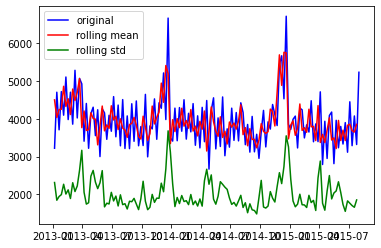

In [212]:
orig = plt.plot(sales_1.resample('W').mean(),color = 'blue',label = 'original')
roll_mean = plt.plot(rollmean.resample('W').mean(),color = 'red',label = 'rolling mean')
orig_std = plt.plot(rollstd.resample('W').mean(),color = 'green',label = 'rolling std')
plt.legend(loc='best')
plt.show(block=False)



# Stationarity Test - ADF Test

In [213]:


def stationary_check(sales):
  result = adfuller(sales,autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values:')
  for key, value in result[4].items():
        print(key,value)

In [214]:
stationary_check(sales_1)

ADF Statistic: -4.374784
p-value: 0.000329
Critical values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [215]:
stationary_check(sales_3)

ADF Statistic: -5.852255
p-value: 0.000000
Critical values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [216]:
stationary_check(sales_8)

ADF Statistic: -3.625652
p-value: 0.005289
Critical values:
1% -3.437470108019385
5% -2.8646832620852853
10% -2.5684436698650503


In [217]:
stationary_check(sales_9)

ADF Statistic: -2.544088
p-value: 0.105112
Critical values:
1% -3.437470108019385
5% -2.8646832620852853
10% -2.5684436698650503


In [218]:
stationary_check(sales_13)

ADF Statistic: -6.237461
p-value: 0.000000
Critical values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [219]:
stationary_check(sales_25)

ADF Statistic: -4.066113
p-value: 0.001101
Critical values:
1% -3.437620518167552
5% -2.8647495822909477
10% -2.568478995776815


In [220]:
stationary_check(sales_29)

ADF Statistic: -3.032433
p-value: 0.031975
Critical values:
1% -3.437470108019385
5% -2.8646832620852853
10% -2.5684436698650503


In [221]:
stationary_check(sales_31)

ADF Statistic: -4.709951
p-value: 0.000081
Critical values:
1% -3.437470108019385
5% -2.8646832620852853
10% -2.5684436698650503


In [222]:
stationary_check(sales_46)

ADF Statistic: -5.343117
p-value: 0.000004
Critical values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


Store 9 appears to be non stationary 

## Plot time series data

# Time series Decomposition

In [223]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=360)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid



    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')

    plt.title('Decomposition for Store')

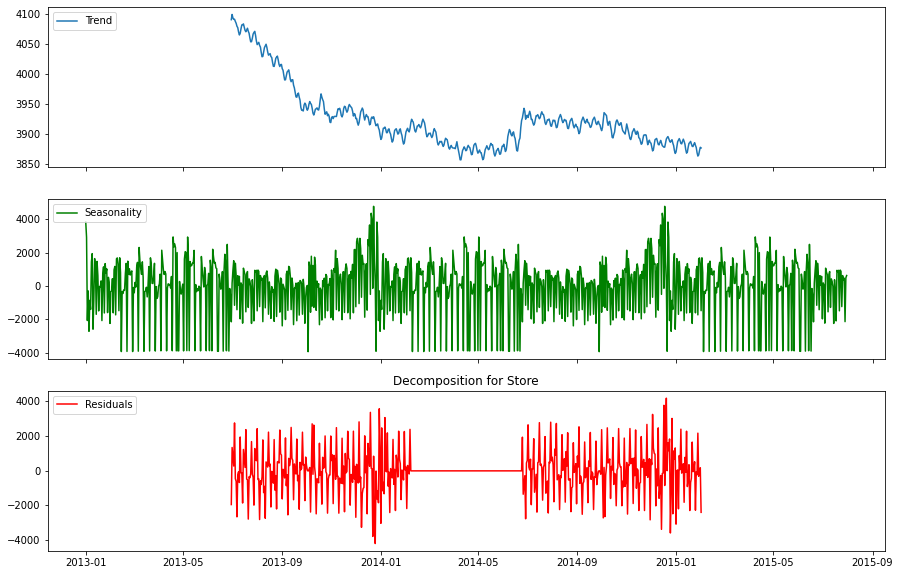

In [224]:
plot_timeseries(sales_1,'c')

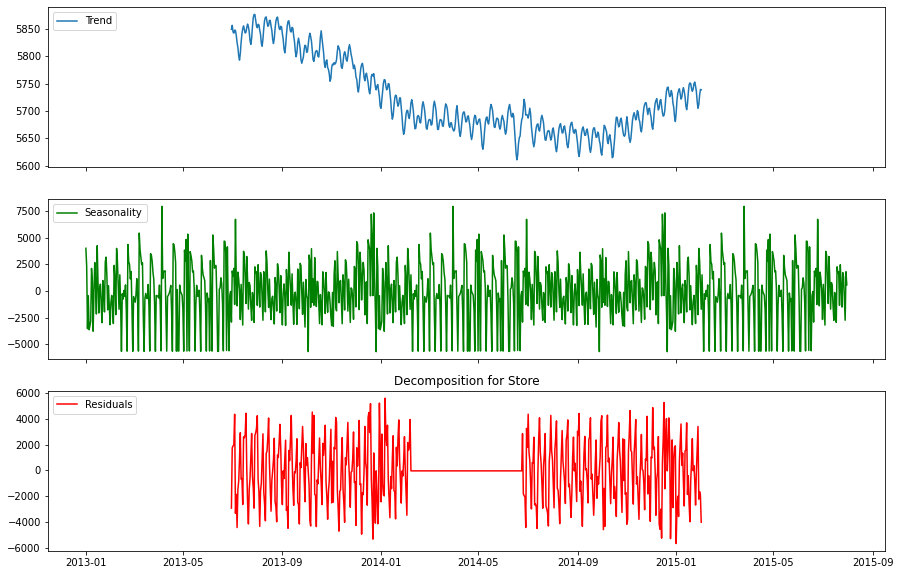

In [225]:
plot_timeseries(sales_3,'a')

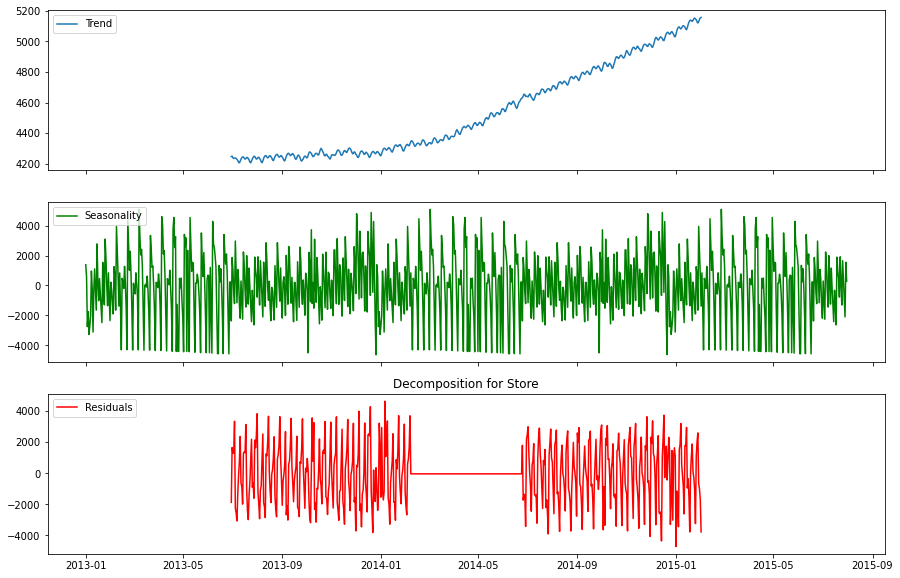

In [226]:
plot_timeseries(sales_8,'a')

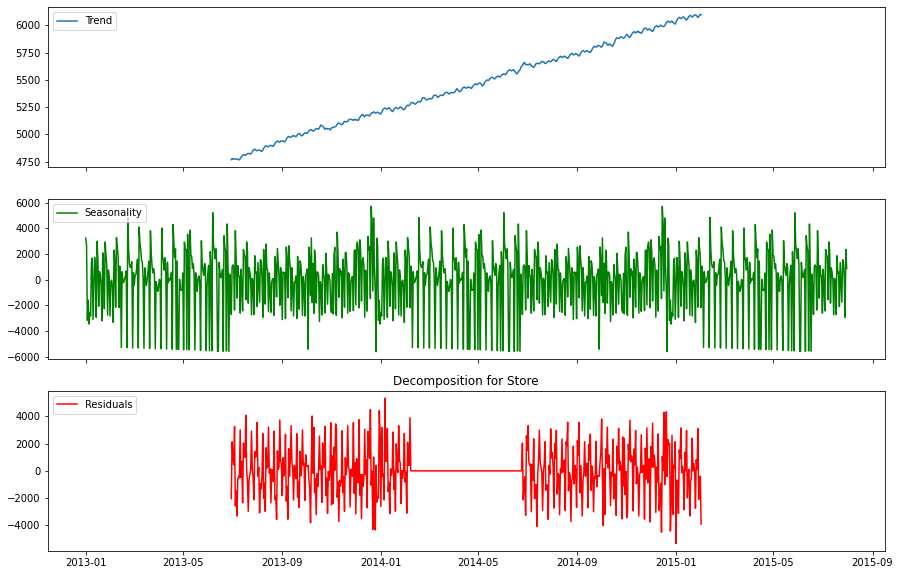

In [227]:
plot_timeseries(sales_9,'a')

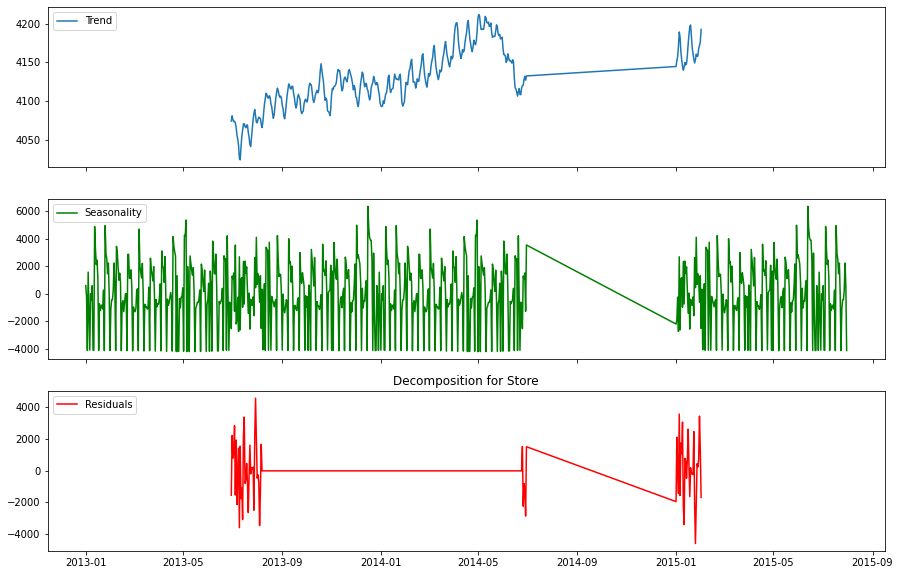

In [228]:
plot_timeseries(sales_13,'d')

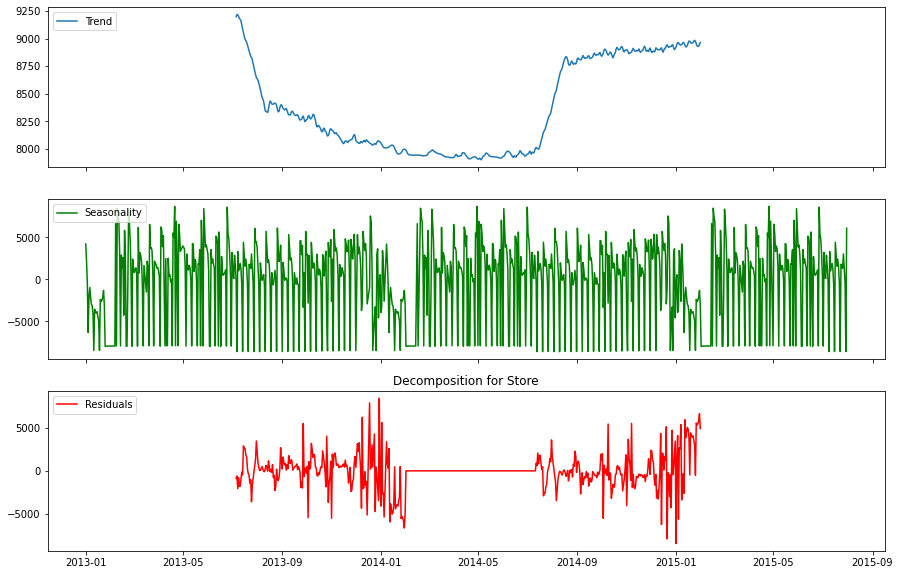

In [229]:
plot_timeseries(sales_25,'c')

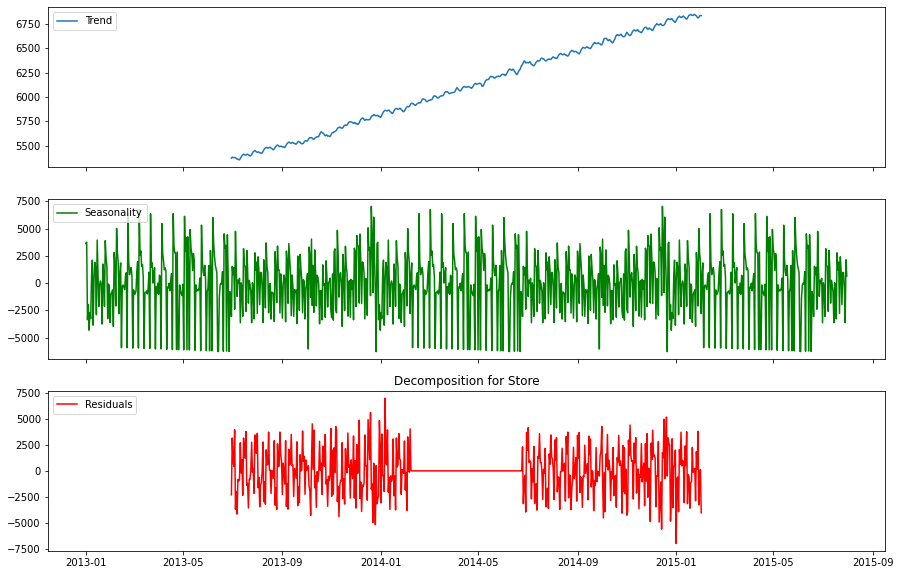

In [230]:
plot_timeseries(sales_29,'d')

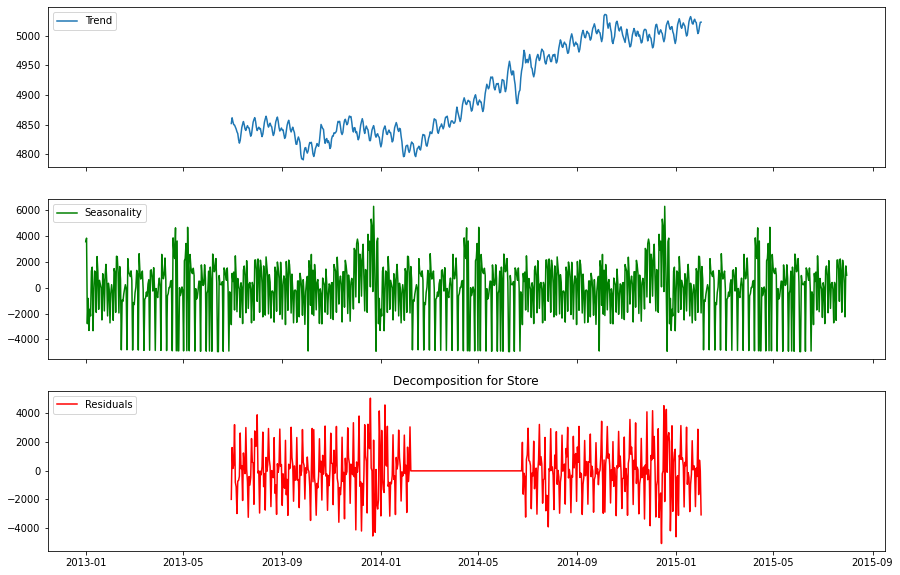

In [231]:
plot_timeseries(sales_31,'d')

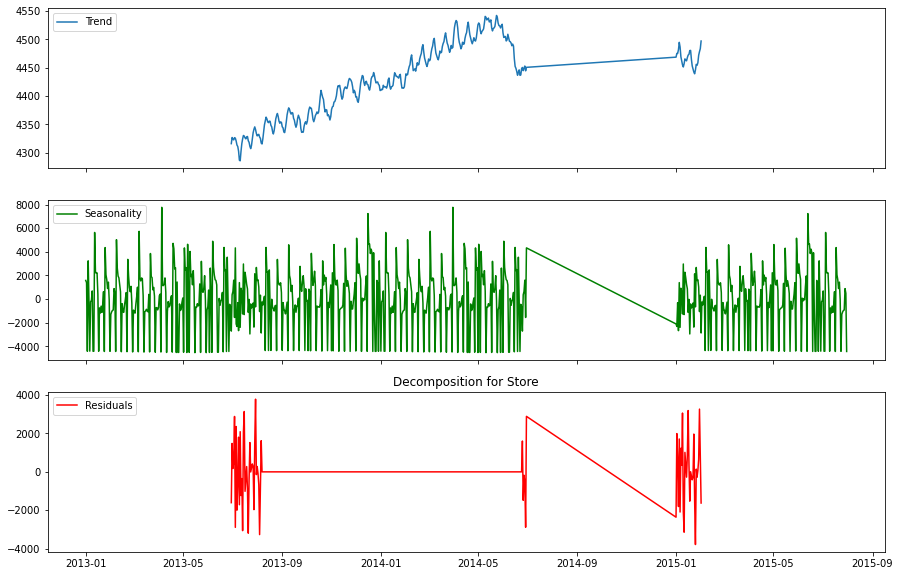

In [232]:
plot_timeseries(sales_46,'c')

# Plotting ACF & PACF <a name="acf-pacf"></a>


In [233]:
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_1)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_1)),linestyle='--',color ='red')
    plt.title('ACF')


    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_1)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_1)),linestyle='--',color ='red')
    plt.title('PACF')

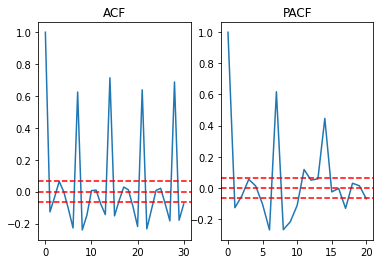

In [234]:
auto_corr(sales_1)

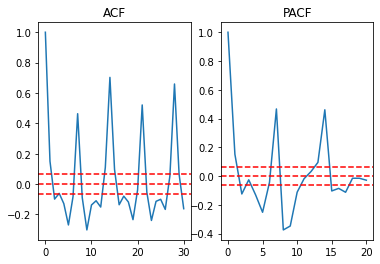

In [235]:
auto_corr(sales_3)

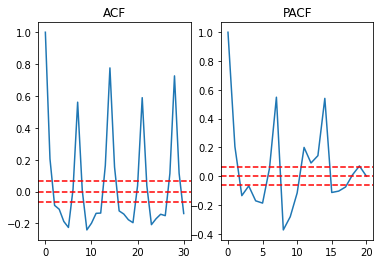

In [236]:
auto_corr(sales_8)  

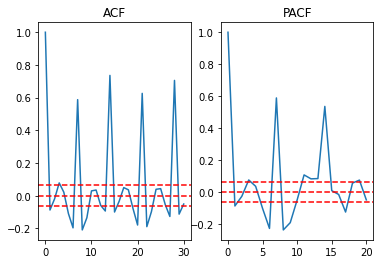

In [237]:
auto_corr(sales_9)

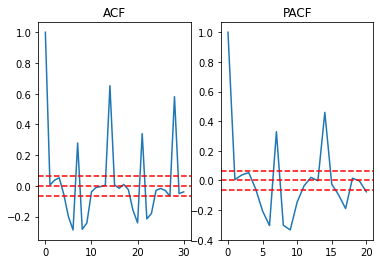

In [238]:
auto_corr(sales_13)

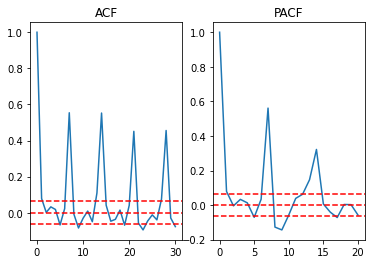

In [239]:
auto_corr(sales_25)

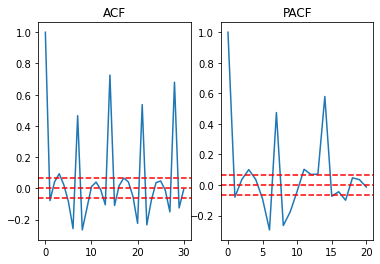

In [240]:
auto_corr(sales_29)

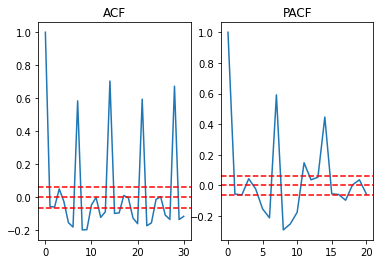

In [241]:
auto_corr(sales_31)

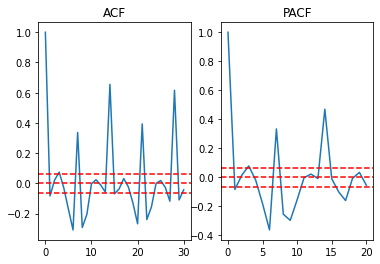

In [242]:
auto_corr(sales_46)

# Model Evaluation

In [243]:
#Based on previous ranges we see that p and q range between 0 and 2

p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [244]:
def sample(sales):
  return(sales.resample('MS').mean())

In [245]:
y_sales_1 = sample(sales_1)
y_sales_3 = sample(sales_3)
y_sales_8 = sample(sales_8)
y_sales_9 = sample(sales_9)
y_sales_13 = sample(sales_13)
y_sales_25 = sample(sales_25)
y_sales_29 = sample(sales_29)
y_sales_31 = sample(sales_31)
y_sales_46 = sample(sales_46)

In [246]:
def model(i,sale):
  ex = df2.loc[df2['Store'] == i,['Customers','Promo']]
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [247]:
y_sales_model_1 , exog_1 = model(1,sales_1)
y_sales_model_3 , exog_3 = model(3,sales_3)
y_sales_model_8 , exog_8 = model(8,sales_8)
y_sales_model_9 , exog_9 = model(9,sales_9)
y_sales_model_13 , exog_13 = model(13,sales_13)
y_sales_model_25 , exog_25 = model(25,sales_25)
y_sales_model_29 , exog_29 = model(29,sales_29)
y_sales_model_31 , exog_31 = model(31,sales_31)
y_sales_model_46 , exog_46 = model(46,sales_46)


In [248]:
exog_1 = exog_1.dropna()
exog_1.isna().sum()

exog_3 = exog_3.dropna()
exog_3.isna().sum()

exog_8 = exog_8.dropna()
exog_8.isna().sum()

exog_9 = exog_9.dropna()
exog_9.isna().sum()

exog_13 = exog_13.dropna()
exog_13.isna().sum()

exog_25 = exog_25.dropna()
exog_25.isna().sum()

exog_29 = exog_29.dropna()
exog_29.isna().sum()

exog_31 = exog_31.dropna()
exog_31.isna().sum()

exog_46 = exog_46.dropna()
exog_46.isna().sum()

const        0
Customers    0
Promo        0
dtype: int64

# Seasonal auto regressive integrate moving average with exogenous variable (SARIMAX)

In [249]:
def arima(y_sale,exog,or1,sord):
    mod = sm.tsa.statespace.SARIMAX(y_sale,
                                    exog,
                                    order=or1,
                                    seasonal_order=sord,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)



    results = mod.fit(disp=0)
    ## -----------------------predictions-------------------
    pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'), dynamic=False)
    pred_ci = pred.conf_int()

   ##------------------------plot-----------------------------
    ax = y_sale['2013':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                      pred_ci.iloc[:, 1],
                      pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('sales')
    plt.legend()

    plt.show()


    y_pred = pred.predicted_mean
    y_true = y_sale['2015-01-01':'2015-07-01']

   ##-------------Compute the mean square error and mean ablsote percentage error----------------
    mse = ((y_pred - y_true) ** 2).mean()
    rmse = np.sqrt(((y_pred - y_true) ** 2).mean())
    rmspe =  np.sqrt(np.mean((y_pred/y_true) ** 2))
    mape = np.mean(np.abs((y_true-y_pred)/y_true)) *100
   
    return results , mse,rmse,rmspe,mape

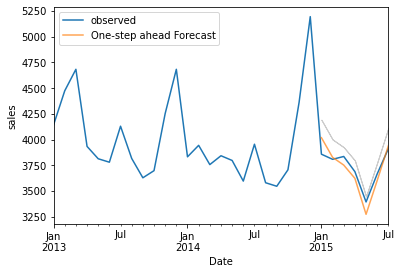

                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   31
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -165.711
Date:                Mon, 13 Sep 2021   AIC                            345.422
Time:                        14:31:45   BIC                            354.748
Sample:                    01-01-2013   HQIC                           348.273
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0463   5404.278   8.57e-06      1.000   -1.06e+04    1.06e+04
Customers      9.6504      0.526     18.358      0.000       8.620      10.681
Promo        -76.4050    312.371     -0.245      0.8

In [250]:
or_1 = (2,1,1)
sord_1=(0, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_1,exog_1,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

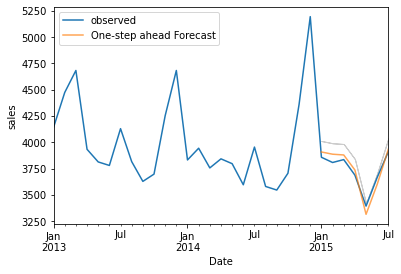

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -103.312
Date:                            Mon, 13 Sep 2021   AIC                            218.623
Time:                                    14:31:46   BIC                            224.290
Sample:                                01-01-2013   HQIC                           219.582
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -96.0421    382.133     -0.251      0.802    -845.009     652.924
Customers      9.1321      0.624   

In [251]:
or_1 = (0,0,1)
sord_1=(1, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_1,exog_1,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

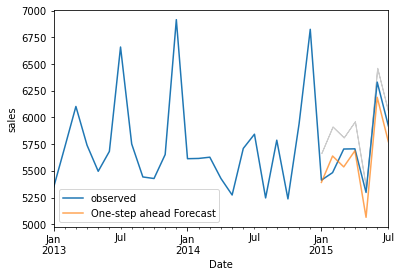

                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   31
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -178.480
Date:                Mon, 13 Sep 2021   AIC                            370.959
Time:                        14:31:46   BIC                            380.285
Sample:                    01-01-2013   HQIC                           373.810
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1168.5293   5802.001     -0.201      0.840   -1.25e+04    1.02e+04
Customers     11.4337      1.154      9.904      0.000       9.171      13.696
Promo       1207.4959    956.218      1.263      0.2

In [252]:
or_1 = (1,0,2)
sord_1=(0, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_3,exog_3,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

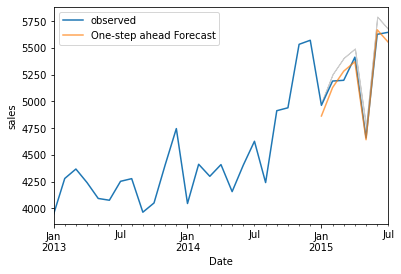

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(0, 1, 2)x(1, 1, 0, 12)   Log Likelihood                 -33.382
Date:                            Mon, 13 Sep 2021   AIC                             80.764
Time:                                    14:31:47   BIC                             79.306
Sample:                                01-01-2013   HQIC                            74.929
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017   1.38e+06  -1.23e-09      1.000   -2.71e+06    2.71e+06
Customers      7.6888     14.997   

In [253]:
or_1 = (0,1,2)
sord_1=(1, 1, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_8,exog_8,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

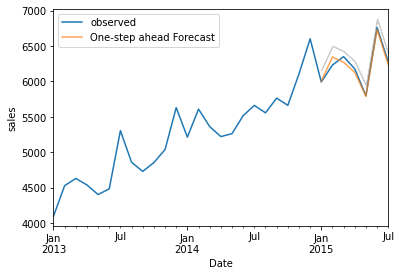

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(5, 0, 2)x(1, 0, 0, 12)   Log Likelihood                 -80.111
Date:                            Mon, 13 Sep 2021   AIC                            184.221
Time:                                    14:31:48   BIC                            191.890
Sample:                                01-01-2013   HQIC                           183.511
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1645.7249   9169.191     -0.179      0.858   -1.96e+04    1.63e+04
Customers     13.4857      9.243   

In [254]:
or_1 = (5,0,2)
sord_1=(1, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_9,exog_9,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

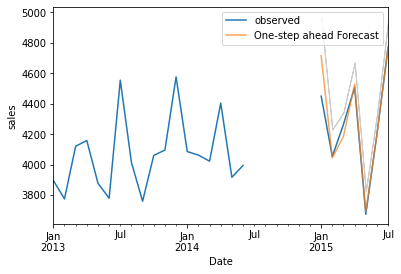

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 12)   Log Likelihood                 -75.883
Date:                            Mon, 13 Sep 2021   AIC                            165.767
Time:                                    14:38:24   BIC                            172.378
Sample:                                01-01-2013   HQIC                           166.886
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1252.5537   2913.932      0.430      0.667   -4458.648    6963.755
Customers      6.7903      4.732   

In [275]:
or_1 = (0,0,2)
sord_1=(1, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_13,exog_31,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

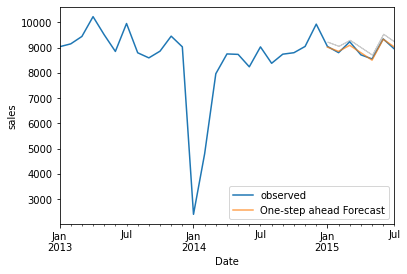

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -112.220
Date:                            Mon, 13 Sep 2021   AIC                            238.440
Time:                                    14:34:41   BIC                            244.672
Sample:                                01-01-2013   HQIC                           239.299
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -402.0950   3731.219     -0.108      0.914   -7715.150    6910.960
Customers      6.6217      0.190   

In [258]:
or_1 = (1,0,1)
sord_1=(1, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_25,exog_25,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

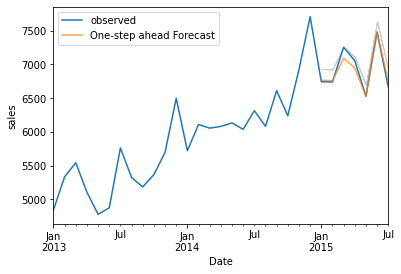

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -105.356
Date:                            Mon, 13 Sep 2021   AIC                            224.711
Time:                                    14:34:41   BIC                            230.944
Sample:                                01-01-2013   HQIC                           225.571
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2179.5640   1261.146     -1.728      0.084   -4651.365     292.237
Customers     12.1507      1.539   

In [259]:
or_1 = (1,0,1)
sord_1=(1, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_29,exog_29,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

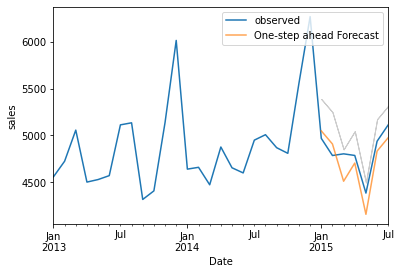

                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   31
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -197.346
Date:                Mon, 13 Sep 2021   AIC                            404.691
Time:                        14:34:42   BIC                            411.697
Sample:                    01-01-2013   HQIC                           406.933
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2395.1714    834.624     -2.870      0.004   -4031.004    -759.339
Customers     14.2727      1.224     11.661      0.000      11.874      16.672
Promo        849.6771    841.328      1.010      0.3

In [260]:
or_1 = (1,0,0)
sord_1=(0, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_31,exog_31,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

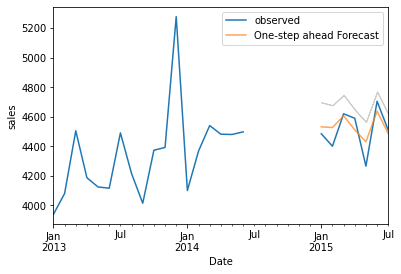

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 0, 2)x(1, 0, 0, 12)   Log Likelihood                 -68.647
Date:                            Mon, 13 Sep 2021   AIC                            153.293
Time:                                    14:39:07   BIC                            160.416
Sample:                                01-01-2013   HQIC                           154.275
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4184.4828    291.879     14.336      0.000    3612.411    4756.554
Customers      0.1821      0.383   

In [277]:
or_1 = (1,0,2)
sord_1=(1, 0, 0, 12)
result_1,mse_1,rmse_1,rmspe_1,mape_1= arima(y_sales_model_46,exog_25,or_1,sord_1)
print(result_1.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_1, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_1, 2)))
print('The Mean Absolute Percentage Error is {}'.format(round(mape_1, 2)))

In [263]:
df_test = df_test[df_test['Open']!=0]
df_test = df_test[df_test['Sales']>0]
df_train = df_train[df_train['Open']!=0]
df_train = df_train[df_train['Sales']>0]

In [264]:
df_train.drop(['Open','PromoInterval','MonthName'],axis=1,inplace =True)
df_test.drop(['Open','PromoInterval','MonthName'],axis=1,inplace =True)

In [265]:
df_train_x = df_train.drop(['Sales'],axis=1 )
df_train_y = np.log1p(df_train.Sales)
df_test_x = df_test.drop(['Sales'],axis=1 )
df_test_y = np.log1p(df_test.Sales)

In [266]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)
def mape_xg(yhat, y):
    labels = y.get_label()
    return ("mape",-np.mean(np.abs((labels - yhat)/(labels+1))))
def xgb_mape(preds, dtrain):
   labels = dtrain.get_label()
   return('mape', np.mean(np.abs((labels - preds) / (labels+1))))



Trying XGboost for better result

# XGBoost

In [267]:
dtrain = xgb.DMatrix(df_train_x, df_train_y)
dvalid = xgb.DMatrix(df_test_x, df_test_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [268]:
params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 6000           #countinue for 6000 itertions


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=mape_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))


print("validating")
df_test_x.sort_index(inplace=True) 
df_test_y.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(df_test_x))
#error = mape_xg(yhat,df_test_y)

#print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[0]	train-rmse:7.96132	eval-rmse:8.02041	train-mape:-0.819753	eval-mape:-0.820833
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 100 rounds.
[1]	train-rmse:7.72292	eval-rmse:7.78172	train-mape:-0.79516	eval-mape:-0.796364
[2]	train-rmse:7.49157	eval-rmse:7.54979	train-mape:-0.771306	eval-mape:-0.7726
[3]	train-rmse:7.26719	eval-rmse:7.32485	train-mape:-0.74817	eval-mape:-0.749551
[4]	train-rmse:7.04955	eval-rmse:7.10672	train-mape:-0.725728	eval-mape:-0.727198
[5]	train-rmse:6.83844	eval-rmse:6.89507	train-mape:-0.703959	eval-mape:-0.705511
[6]	train-rmse:6.63363	eval-rmse:6.68983	train-mape:-0.68284	eval-mape:-0.68448
[7]	train-rmse:6.43508	eval-rmse:6.49076	train-mape:-0.662352	eval-mape:-0.664066
[8]	train-rmse:6.24237	eval-rmse:6.29754	train-mape:-0.642465	eval-mape:-0.644251
[9]	train-rmse:6.05542	eval-rmse:6.1101	train-mape:-0.623187	eval-mape:-0.625043
[10]	train-rmse:5.874

In [269]:
params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 6000           #countinue for 6000 itertions


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))


print("validating")
df_test_x.sort_index(inplace=True) 
df_test_y.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(df_test_x))
error = rmspe(np.expm1(df_test_y), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[0]	train-rmse:7.96132	eval-rmse:8.02041	train-rmspe:0.999803	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.72292	eval-rmse:7.78172	train-rmspe:0.999703	eval-rmspe:0.999721
[2]	train-rmse:7.49157	eval-rmse:7.54979	train-rmspe:0.999581	eval-rmspe:0.999606
[3]	train-rmse:7.26719	eval-rmse:7.32485	train-rmspe:0.999432	eval-rmspe:0.999466
[4]	train-rmse:7.04955	eval-rmse:7.10672	train-rmspe:0.999252	eval-rmspe:0.999297
[5]	train-rmse:6.83844	eval-rmse:6.89507	train-rmspe:0.999037	eval-rmspe:0.999094
[6]	train-rmse:6.63363	eval-rmse:6.68983	train-rmspe:0.99878	eval-rmspe:0.998852
[7]	train-rmse:6.43508	eval-rmse:6.49076	train-rmspe:0.998475	eval-rmspe:0.998564
[8]	train-rmse:6.24237	eval-rmse:6.29754	train-rmspe:0.998116	eval-rmspe:0.998225
[9]	train-rmse:6.05542	eval-rmse:6.1101	train-rmspe:0.997696	eval-rmspe:0.997828
[10]	train-rms

In [270]:
df_predict = pd.DataFrame(yhat)
df_predict.head()

,0
0,9.048150
1,8.359860
2,8.658957
3,8.963347
4,9.263300


In [271]:
# analysis by hold-out set
res = pd.DataFrame(data = df_test_y)
res['Prediction']=yhat
res = pd.merge(df_test_x,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,day,month,year,weekofyear,Sales/Cust,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31,25,3,925,0,0,1,3,1,430.0,4.0,2003.0,0,0.0,2011.0,31,12,2014,1,8.401081,140.0,36.25,0,8.958283,9.048150,1.010032,0.010032,0.990068
2015-01-02,46,5,615,0,0,1,3,1,1200.0,9.0,2005.0,1,14.0,2011.0,2,1,2015,1,6.743089,112.0,44.75,1,8.330382,8.359860,1.003539,0.003539,0.996474
2015-01-02,46,5,615,0,0,1,3,1,1200.0,9.0,2005.0,1,14.0,2011.0,2,1,2015,1,6.743089,112.0,44.75,1,8.666992,8.658957,0.999073,0.000927,1.000928
2015-01-02,46,5,615,0,0,1,3,1,1200.0,9.0,2005.0,1,14.0,2011.0,2,1,2015,1,6.743089,112.0,44.75,1,8.980927,8.963347,0.998043,0.001957,1.001961
2015-01-02,46,5,615,0,0,1,3,1,1200.0,9.0,2005.0,1,14.0,2011.0,2,1,2015,1,6.743089,112.0,44.75,1,9.314790,9.263300,0.994472,0.005528,1.005559


In [272]:
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,day,month,year,weekofyear,Sales/Cust,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-15,31,3,532,1,0,0,4,3,9800.0,7.0,2012.0,0,0.0,2011.0,15,7,2015,29,11.842105,36.0,55.25,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,1,3,550,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,2011.0,15,7,2015,29,8.667273,82.0,55.25,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,9,3,633,1,0,1,1,3,2030.0,8.0,2000.0,0,0.0,2011.0,15,7,2015,29,11.078989,179.0,55.25,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,3,3,865,1,0,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,15,7,2015,29,10.015029,103.0,51.75,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,8,3,802,1,0,0,1,1,7520.0,10.0,2014.0,0,0.0,2011.0,15,7,2015,29,9.890274,9.0,55.25,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,29,3,678,1,0,1,4,3,2170.0,9.0,2013.0,0,0.0,2011.0,15,7,2015,29,12.364307,22.0,55.25,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,46,3,635,1,0,0,3,1,1200.0,9.0,2005.0,1,14.0,2011.0,15,7,2015,29,8.214173,118.0,51.75,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,25,3,1406,1,0,1,3,1,430.0,4.0,2003.0,0,0.0,2011.0,15,7,2015,29,8.656472,147.0,55.25,1,9.243291,8.745070,0.946099,0.053901,1.056972
2015-07-15,13,3,415,1,0,0,4,1,310.0,9.0,2013.0,1,45.0,2009.0,15,7,2015,29,24.901205,22.0,68.00,0,9.243291,8.745070,0.946099,0.053901,1.056972


weight correction
RMSPE for 0.990:0.092218
RMSPE for 0.991:0.084520
RMSPE for 0.992:0.076818
RMSPE for 0.993:0.069137
RMSPE for 0.994:0.061512
RMSPE for 0.995:0.053998
RMSPE for 0.996:0.046688
RMSPE for 0.997:0.039741
RMSPE for 0.998:0.033437
RMSPE for 0.999:0.028281
RMSPE for 1.000:0.025069
RMSPE for 1.001:0.024657
RMSPE for 1.002:0.027246
RMSPE for 1.003:0.032182
RMSPE for 1.004:0.038628
RMSPE for 1.005:0.046001
RMSPE for 1.006:0.053962
RMSPE for 1.007:0.062321
RMSPE for 1.008:0.070971
RMSPE for 1.009:0.079845
Best weight for Score:1.001    0.024657
dtype: float64


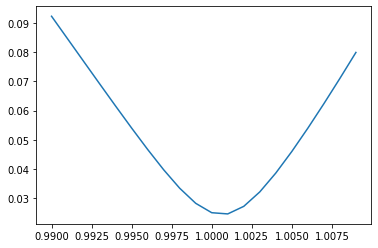

In [273]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(df_test_y), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [274]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')